# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path
if Path.cwd().name != 'LightGlue':
  !git clone --quiet https://github.com/cvg/LightGlue/
  %cd LightGlue
  !pip install --progress-bar off --quiet -e .
    
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
torch.set_grad_enabled(False);
images = Path('assets')

## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint').eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /home/lnt/.cache/torch/hub/checkpoints/superpoint_v1.pth
100.0%
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /home/lnt/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv-pth
40.7%IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100.0%


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

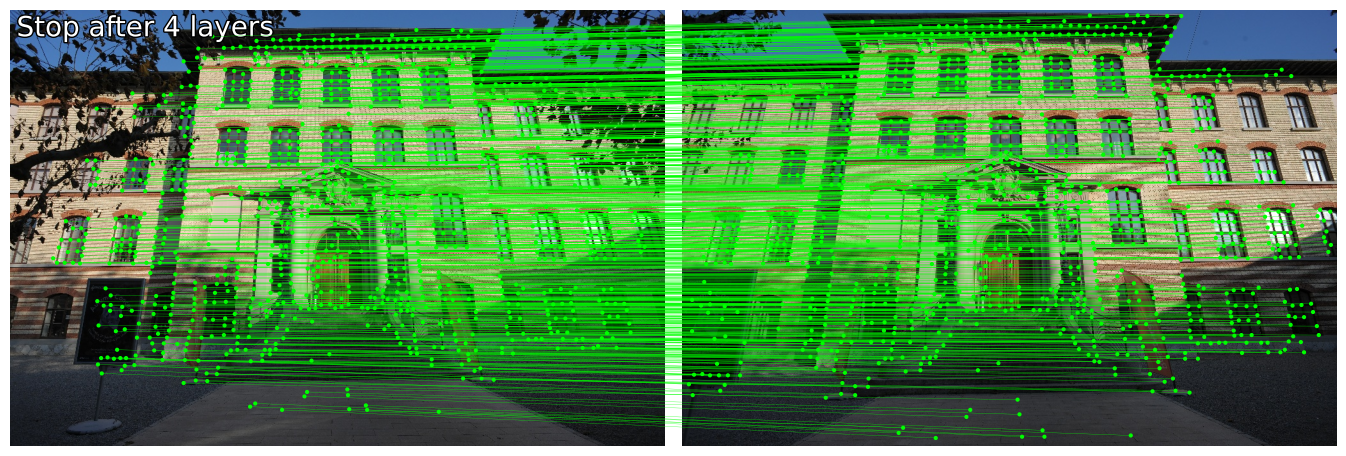

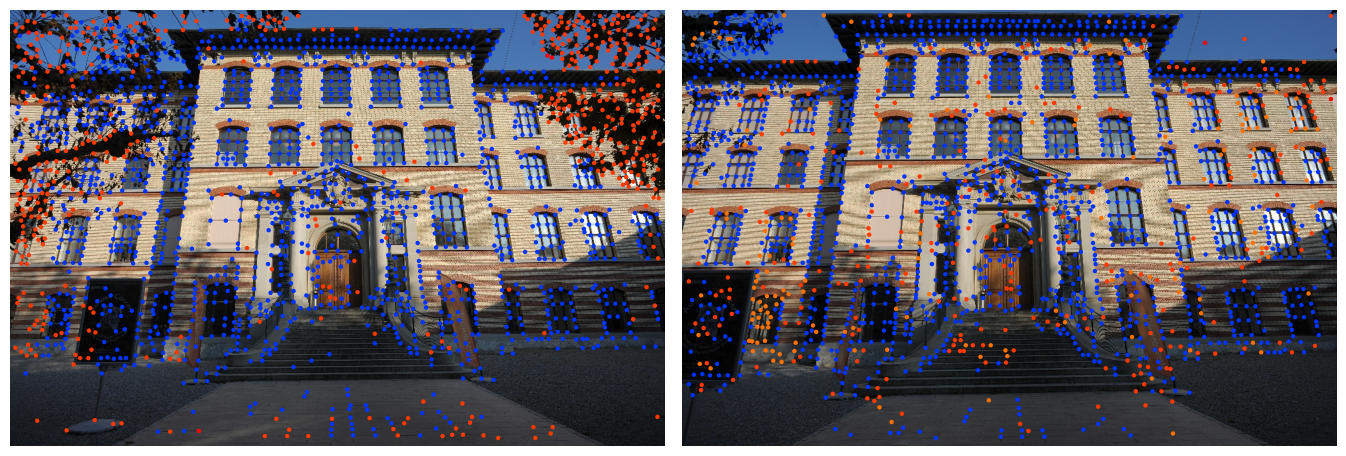

In [4]:
image0 = load_image(images / 'DSC_0411.JPG')
image1 = load_image(images / 'DSC_0410.JPG')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

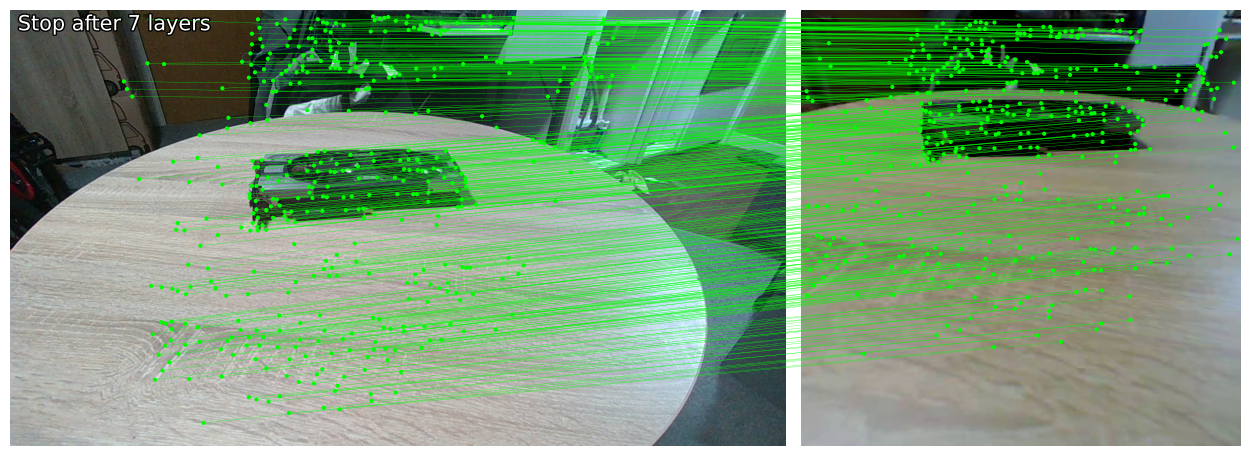

In [20]:
image0 = load_image(images / 'rs.png')
# image0 = load_image(images / 'sacre_coeur1.jpg')
# image1 = load_image(images / 'sacre_coeur2.jpg')
image1 = load_image(images / 'pupil_undistorted.png')

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

kpts0, kpts1, matches = feats0['keypoints'], feats1['keypoints'], matches01['matches']
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color='lime', lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01['prune0']), viz2d.cm_prune(matches01['prune1'])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)

In [21]:
matches

tensor([[   3,  733],
        [   4, 1267],
        [   6,  438],
        [   7,  820],
        [  12, 1934],
        [  14,  844],
        [  16,  499],
        [  18,  569],
        [  20,  923],
        [  21,  199],
        [  23, 1670],
        [  24,  688],
        [  27,  843],
        [  29,  698],
        [  33, 1403],
        [  35, 1417],
        [  38, 1279],
        [  40, 1282],
        [  45, 1114],
        [  46,  967],
        [  47, 1900],
        [  48,  129],
        [  49, 1728],
        [  50,  377],
        [  53,  664],
        [  55,  368],
        [  57,  191],
        [  58,  194],
        [  60, 1526],
        [  61,  666],
        [  63, 1161],
        [  64, 1657],
        [  68, 1312],
        [  70, 1508],
        [  74, 1177],
        [  77,  509],
        [  81, 1269],
        [  82,  741],
        [  84, 1047],
        [  86,  934],
        [  87, 1117],
        [  89,  114],
        [  93, 1309],
        [  94, 1644],
        [  96,  336],
        [ 

In [22]:
import cv2


pupil_video = '/home/lnt//Datasets/pupil/ISO12233/PI world v1 ps1.mp4'
# pupil_video = '/home/lnt//Datasets/pupil/lightglue/PI world v1 ps1.mp4'
cap = cv2.VideoCapture(pupil_video)
for _ in range(300):
  ret, frame = cap.read()
  # if frame[0][0][0] != 2:
  #   break

In [10]:
frame[0][0][0]

2

In [15]:
import matplotlib.pyplot as plt
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)

In [23]:
cv2.imwrite('pupil_iso12233.png', frame)

True